# Surface Circulation — NEMO GYRE

Analyse surface currents from the GYRE simulation.
- Surface current vectors
- Surface kinetic energy

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

from gyre import (
    load_output, load_mesh, interior_mask, grid_angle,
    interp_uv_to_t, rotate_to_geo, gyre_map,
)

plt.rcParams.update({"font.size": 16, "axes.titlesize": 18, "axes.labelsize": 14})

OUTPUT_DIR = Path("../output")

## Load simulation output

Load grid_U, grid_V (velocities) and grid_T (coordinates). Velocities
live on staggered grids (U- and V-points); they are interpolated to
T-points before rotation to geographic coordinates.

In [2]:
ds_u = load_output("*_grid_U.nc", OUTPUT_DIR)
ds_v = load_output("*_grid_V.nc", OUTPUT_DIR)
ds_t = load_output("*_grid_T.nc", OUTPUT_DIR)
mesh = load_mesh(OUTPUT_DIR)

angle = grid_angle(mesh)
interior = interior_mask(mesh.tmask.isel(nav_lev=0), border=2)

## Surface current vectors

Time-mean surface velocity field, rotated from grid-aligned (i, j)
to geographic (east, north) coordinates.

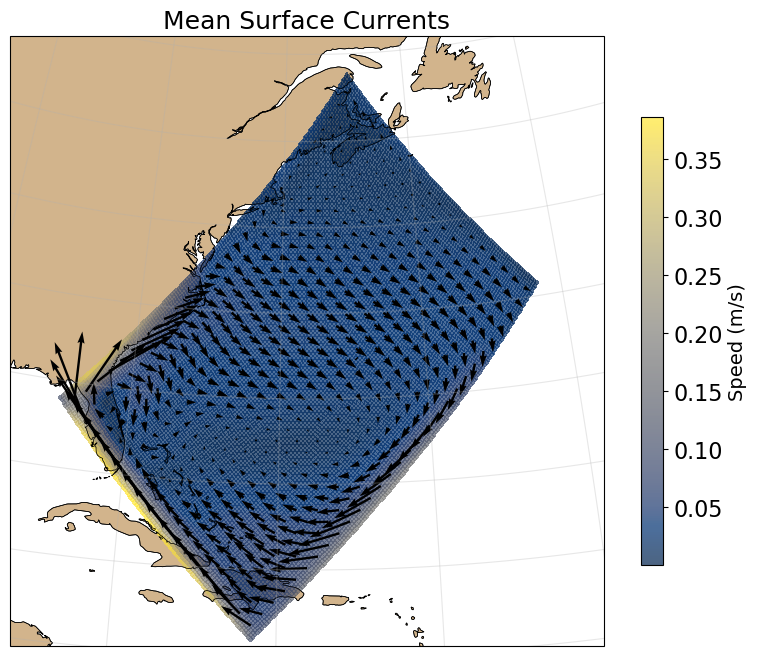

In [3]:
# Time-mean surface velocities
u_sfc = ds_u["vozocrtx"].isel(nav_lev=0).mean("time_counter")
v_sfc = ds_v["vomecrty"].isel(nav_lev=0).mean("time_counter")

# Interpolate to T-points so both components are co-located, then rotate
u_on_t, v_on_t = interp_uv_to_t(u_sfc, v_sfc)
u_east, v_north = rotate_to_geo(u_on_t, v_on_t, angle)
speed = np.sqrt(u_east**2 + v_north**2).where(interior)

fig, ax = gyre_map(ds=ds_t)

pcm = ax.pcolormesh(
    ds_t.nav_lon.values, ds_t.nav_lat.values, speed.values,
    shading="auto", cmap="cividis", alpha=0.7, transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="Speed (m/s)", shrink=0.7)

skip = 5
u_plot = u_east.where(interior)
v_plot = v_north.where(interior)
ax.quiver(
    ds_t.nav_lon.values[::skip, ::skip], ds_t.nav_lat.values[::skip, ::skip],
    u_plot.values[::skip, ::skip], v_plot.values[::skip, ::skip],
    color="k", scale=1.5, width=0.004, transform=ccrs.PlateCarree(),
)
ax.set_title("Mean Surface Currents")
fig.tight_layout()
fig.savefig("../figures/surface_currents.png", dpi=150, bbox_inches="tight")

## Surface kinetic energy

Time-mean surface KE = ½(u² + v²).

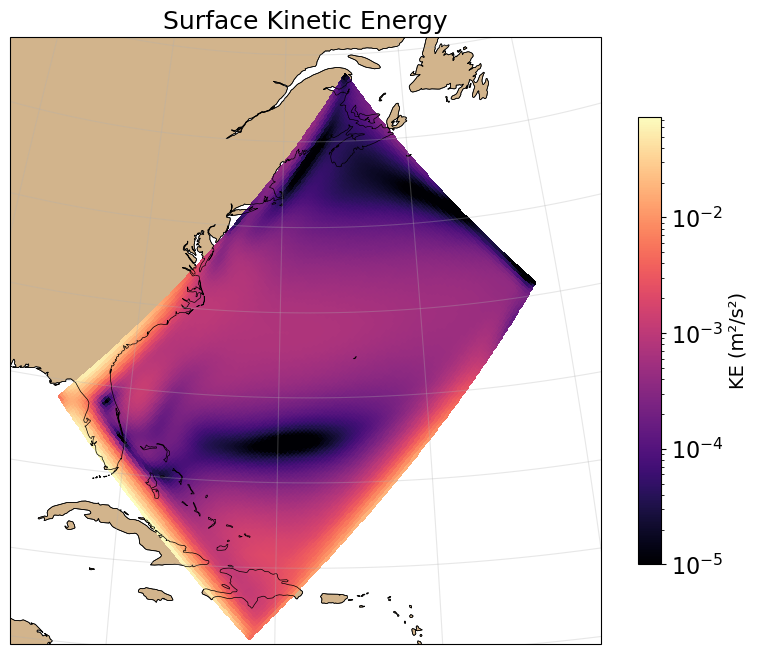

In [4]:
ke = (0.5 * (u_east**2 + v_north**2)).where(interior)

fig, ax = gyre_map(ds=ds_t)

pcm = ax.pcolormesh(
    ds_t.nav_lon.values, ds_t.nav_lat.values, ke.values,
    shading="auto", cmap="magma",
    norm=mcolors.LogNorm(vmin=1e-5, vmax=float(ke.max())),
    transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="KE (m²/s²)", shrink=0.7)
ax.set_title("Surface Kinetic Energy")
fig.tight_layout()
fig.savefig("../figures/surface_ke.png", dpi=150, bbox_inches="tight")